This notebook simulates fluorescent melt curves predicted from NUPACK.

Yuxi, April 2022

# Load stuffs

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
80.98% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216.CPvariant.gz
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin
81.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
31.22% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


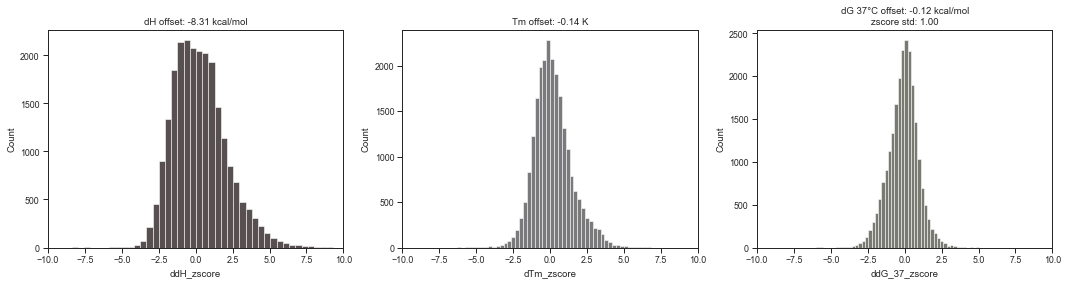

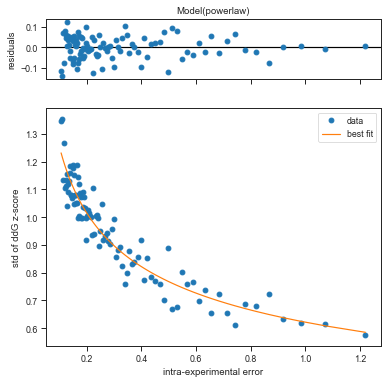

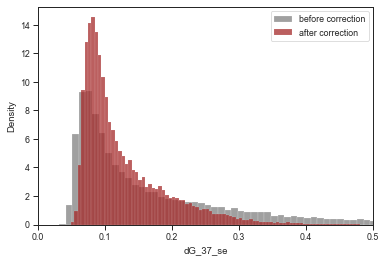

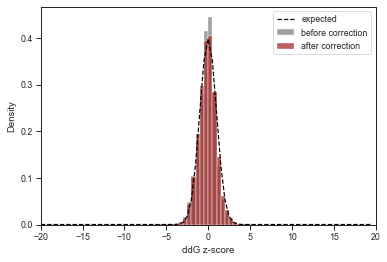

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import json
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from RiboGraphViz import RGV
from RiboGraphViz import LoopExtruder, StackExtruder
from ipynb.draw import draw_struct

from nnn import util, fileio, processing, plotting, motif_fit, simulation
from nnn.arraydata import ErrorAdjust, ArrayData

import warnings
warnings.filterwarnings("ignore")

annotation = fileio.read_annotation('./data/annotation/nnnlib2b_annotation_20220329.tsv')
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:3,:],
                      annotation_file='./data/annotation/NNNlib2b_annotation_20220328.tsv',
                      learn_error_adjust_from=('r1', 'r2'))
revdata = ArrayData(replicate_df=replicate_df.iloc[3,:],
                   annotation_file='./data/annotation/NNNlib2b_annotation_20220328.tsv')
saltdata = ArrayData(replicate_df=replicate_df.iloc[4,:],
                    annotation_file='./data/annotation/NNNlib2b_annotation_20220328.tsv')

arr = arraydata.data.join(arraydata.annotation).query('pair_prob > 0.5')
for param in ['dG_37', 'dG_37_lb', 'dG_37_ub']:
    arr[f'd{param}'] = util.get_ddX(arr, param, 'ConstructType')
arr['ddG_37_NUPACK_salt_corrected'] = util.get_ddX(arr, 'dG_37_NUPACK_salt_corrected', 'ConstructType')
arr['scaffold'] =arr.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

salt = saltdata.data.join(saltdata.annotation).query('pair_prob > 0.5')
for param in ['dG_37', 'dG_37_lb', 'dG_37_ub']:
    salt[f'd{param}'] = util.get_ddX(salt, param, 'ConstructType')
salt['ddG_37_NUPACK_salt_corrected'] = util.get_ddX(salt, 'dG_37_NUPACK_salt_corrected', 'ConstructType')
salt['ddG_37_NUPACK_150mM'] = util.get_ddX(salt, 'dG_37_NUPACK_150mM', 'ConstructType')
salt['scaffold'] = salt.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

# Distance in nt

In [2]:
from nnn import simulation

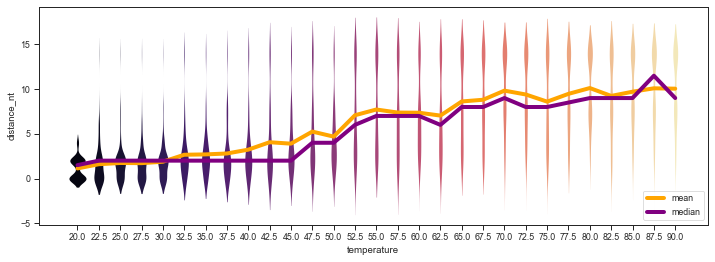

In [9]:
seq = 'AAATAGAAATATTT'
T = np.arange(20, 92.5, 2.5)
simulation.plot_nupack_curve_distance(seq, num_sample=100, sodium=0.15, T=T)
util.save_fig('./fig/simulate_curve/example_distance_nt_dist.pdf')


## Fit distance to fluorescence
Let's find the function from nt distance to fluorescence.

In [23]:
r1 = arraydata.get_replicate_data('r2')
r1 = r1.join(annotation)

Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216.CPvariant.gz
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


In [24]:
repeat_series = r1.query('ConstructType == "RepeatControls"')
repeat_series['length'] = repeat_series.RefSeq.apply(len)
dangle_5p = annotation.query('ConstructType=="strong_stem_var_5prime_dangleAlen"')

In [25]:
conds = [c for c in repeat_series.columns if c.endswith('_norm')]

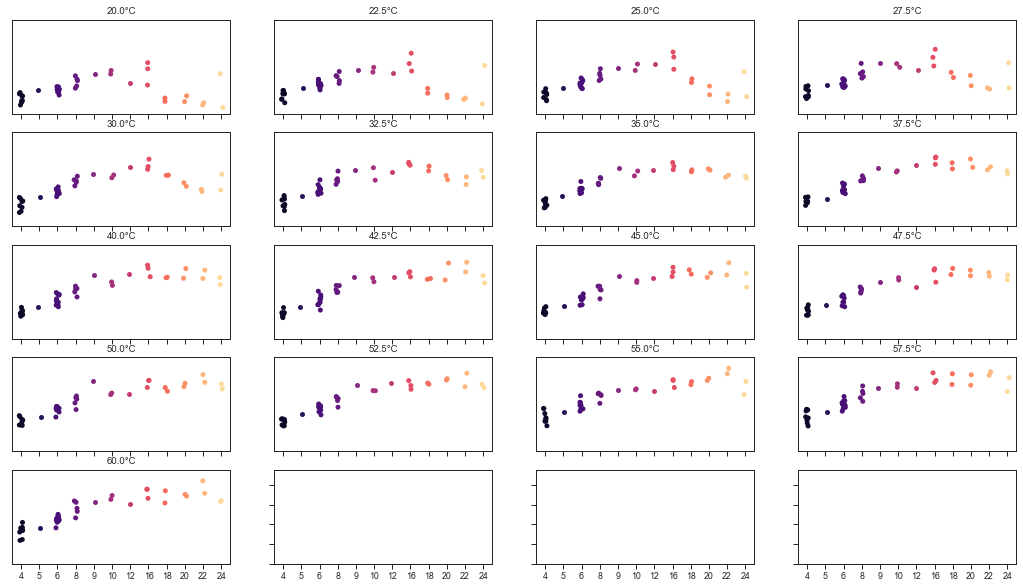

In [26]:
fig, ax = plt.subplots(5,4,figsize=(18,10), sharex=True, sharey=True)
ax = ax.flatten()
for i, cond in enumerate(conds):
    sns.stripplot(data=repeat_series, x='length', y=cond, palette='magma', ax=ax[i])
    ax[i].set_title(cond.split('_')[1] + '°C')
    ax[i].set_ylim([0, 1.2])
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlabel('')

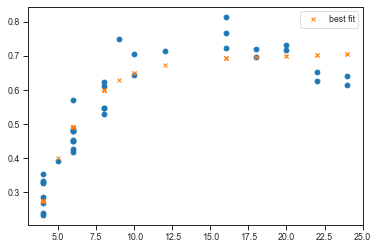

name,value,standard error,relative error,initial value,min,max,vary
a,86.3884420,8.19851417,(9.49%),50,-inf,inf,True
b,0.00000000,0.00000000,,0,0.00000000,inf,False
fmax,0.70859065,0.01487056,(2.10%),0.9,-inf,inf,True
fmin,-0.05000000,0.00000000,(0.00%),-0.05,-inf,inf,False


In [27]:
from lmfit import minimize, Parameters

def residual(params, x, data):
    a = params['a']
    b = params['b']
    fmax = params['fmax']
    fmin = params['fmin']
    
    model = (fmax - fmin) / (1 + (a * (x + b)**(-3))) + fmin
    
    return model - data

fmax, fmin = 0.9, -0.05
params = Parameters()
params.add('a', value=50)
params.add('b', value=0, min=0, vary=False)
params.add('fmax', value=fmax, vary=True)
params.add('fmin', value=fmin, vary=False)

x = np.array(repeat_series['length'], dtype=float)
data = repeat_series[conds[6]]
out = minimize(residual, params, args=(x, data))

plt.plot(x, data, 'o')
plt.plot(x, residual(out.params, x, data) + data, 'x', label='best fit')
plt.legend()
plt.show()
out.params

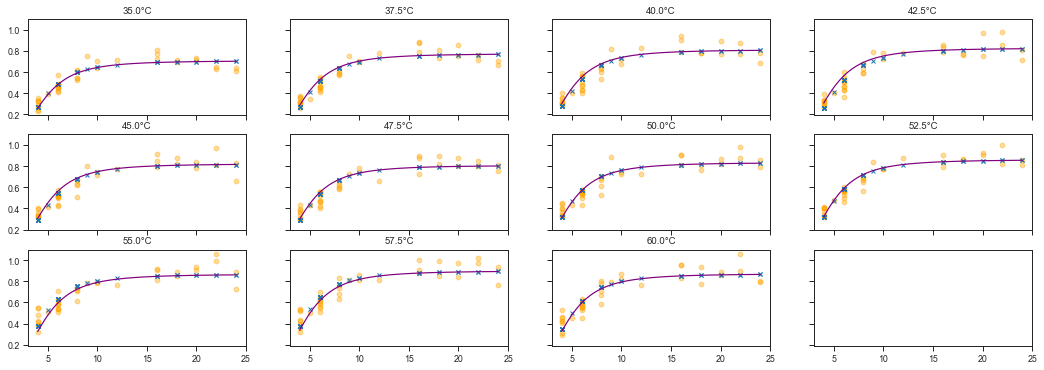

In [29]:
def residual(params, x, data):
    a = params['a']
    b = params['b']
    fmax = params['fmax']
    fmin = params['fmin']
    
    model = (fmax - fmin) / (1 + (a * (x + b)**(-3))) + fmin
    
    return model - data

fmax, fmin = 0.9, -0.05
params = Parameters()
params.add('a', value=50)
params.add('b', value=0, min=0, vary=False)
params.add('fmax', value=fmax, vary=True)
params.add('fmin', value=fmin, vary=False)


fig, ax = plt.subplots(3,4,figsize=(18,6), sharex=True, sharey=True)
ax = ax.flatten()
fitted_a = np.zeros_like(conds[6:])
fitted_fmax = np.zeros_like(conds[6:])
fitted_b = np.zeros_like(conds[6:])

x = np.array(repeat_series['length'], dtype=float)
for i, cond in enumerate(conds[6:]):   
    data = repeat_series[cond]
    out = minimize(residual, params, args=(x, data))

    ax[i].plot(x, data, 'o', c='orange', alpha=.4)
    ax[i].plot(x, residual(out.params, x, data) + data, 'x', label='best fit')
    
    xx = np.linspace(4,24,100)
    a = 93
    y = (float(out.params['fmax'].value) - fmin) / (1 + (a * (xx)**(-3))) + fmin
    ax[i].plot(xx, y, 'purple')
    ax[i].set_title(cond.split('_')[1] + '°C')
    
    # ax[i].set_xlabel('Distance (nt)')
    # ax[i].set_ylabel('Normalized fluorescence')

    fitted_a[i] = float(out.params['a'].value)
    fitted_fmax[i] = float(out.params['fmax'].value)
    fitted_b[i] = float(out.params['b'].value)
    
util.save_fig('./fig/signal_length/fitted_norm_fluor_vs_distance.pdf')
    

In [30]:
fitted_a = fitted_a.astype(float)
fitted_b = fitted_b.astype(float)
fitted_fmax = fitted_fmax.astype(float)

(50.0, 115.77811254071436)

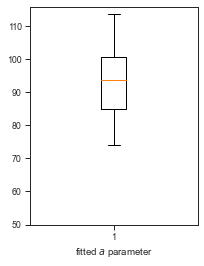

In [32]:

_,_ = plt.subplots(figsize=(3,4))
plt.boxplot(fitted_a)
plt.xlabel('fitted $a$ parameter')
plt.ylim(bottom=50)

Text(0.5, 0, 'fitted $f_{max}$ parameter')

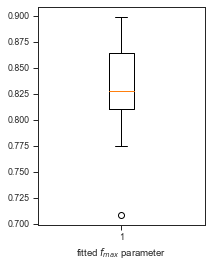

In [164]:

_,_ = plt.subplots(figsize=(3,4))
plt.boxplot(fitted_fmax)
plt.xlabel('fitted $f_{max}$ parameter')

In [33]:
np.mean(fitted_a), np.median(fitted_a)

(92.72627950264234, 93.83887254796186)

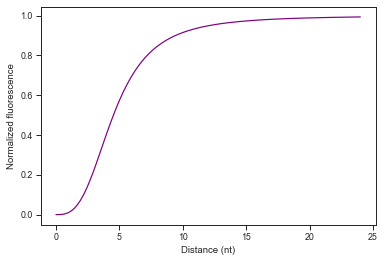

In [177]:
x = np.linspace(0,24,100)
a = 93
y = 1 / (1 + (a * x**(-3)))
plt.plot(x, y, 'purple')
plt.xlabel('Distance (nt)')
plt.ylabel('Normalized fluorescence')

util.save_fig('./fig/signal_length/fitted_norm_fluor_vs_distance_theoretical.pdf')


## Apply transform to the simulated distance distribution

In [88]:
nt_range = np.arange(30)
fluor_curve = simulation.distance_2_norm_fluor(nt_range, a=93)

(-0.1, 1.2)

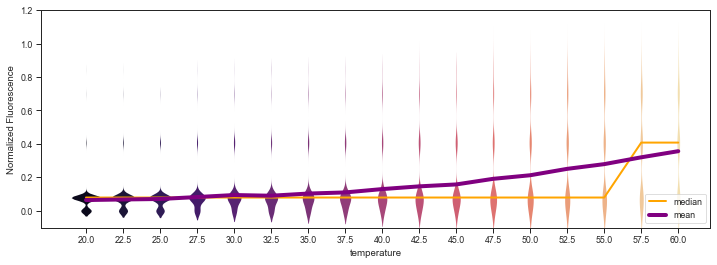

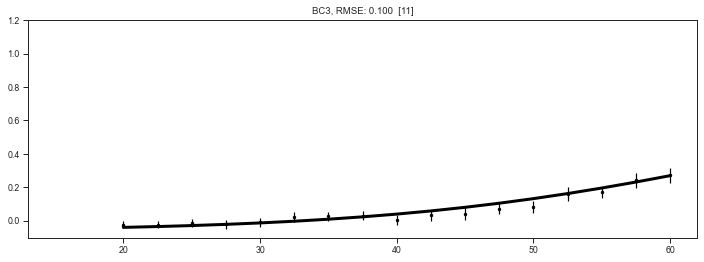

In [165]:
row = r1.iloc[3,:]
seq = row.RefSeq
# simulation.plot_nupack_curve(seq, num_sample=1000, sodium=.05, T=np.arange(20, 62.5, 2.5),
#                                       transform_curve=None)
simulation.plot_nupack_curve(seq, num_sample=1000, sodium=.075, T=np.arange(20, 62.5, 2.5),
                                      transform_curve=fluor_curve)
plt.ylim([-.1, 1.2])
fig, ax = plt.subplots(figsize=(12,4))
plotting.plot_actual_and_expected_fit(row, ax)
ax.set_ylim([-.1, 1.2])

## Fit the simulated curve

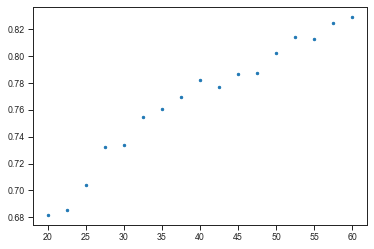

In [144]:
seq = r1.iloc[7,:].RefSeq
y = simulation.simulate_nupack_curve(seq, num_sample=1000, sodium=.05, T=np.arange(20, 62.5, 2.5))
plt.plot(T, y, '.')

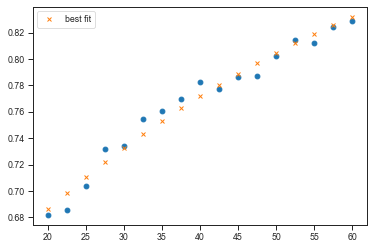

name,value,standard error,relative error,initial value,min,max,vary
dH,-3.95921329,0.16757998,(4.23%),-40,-200.000000,0.00000000,True
Tm,-10.3117945,1.71575463,(16.64%),50,-100.000000,300.000000,True
fmax,1.00000000,0.00000000,(0.00%),1,-inf,inf,False
fmin,0.00000000,0.00000000,,0.0,-inf,inf,False


In [148]:
def residual(params, x, data):
    dH = params['dH']
    Tm = params['Tm']
    fmax = params['fmax']
    fmin = params['fmin']
    kB = 0.0019872
    
    model = fmin + (fmax - fmin) / (1 + np.exp((dH/kB) * (1/(Tm + 273.15) - 1/(T + 273.15))))

    return model - data


fmax, fmin = 0.9, -0.05
params = Parameters()
params.add('dH', value=-40, max=0.0, min=-200.0)
params.add('Tm', value=50, max=300, min= -100)
params.add('fmax', value=1, vary=False)
params.add('fmin', value=0.0, vary=False)

out = minimize(residual, params, args=(T, y))

plt.plot(T, y, 'o')
plt.plot(T, residual(out.params, T, y) + y, 'x', label='best fit')
plt.legend()
plt.show()
out.params

In [149]:
out.params['dH'].value

-3.9592132893182566

## Get the entire CPseries df

In [166]:
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_20220418.tsv')

In [168]:
annotation.shape[0]

42177

In [206]:
curves = simulation.simulate_CPseries(annotation.sample(30), T=np.arange(5, 97.5, 2.5))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [207]:
curves.shape

(30, 35)

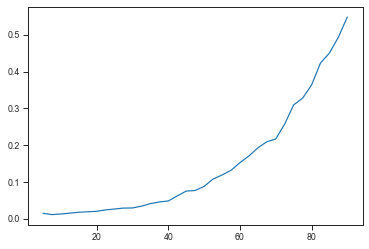

In [210]:
plt.plot(np.arange(5, 92.5, 2.5), curves[3,:])